In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

from pysim import SimBoostRegressor, SimBoostClassifier

## Regression

In [2]:
random_state = 0
np.random.seed(random_state)
# data generation
beta1 = np.array([.2, 0.3, 0.5, 0, 0, 0, 0, 0, 0, 0])
beta2 = np.array([0, .2, 0.3, 0.5, 0, 0, 0, 0, 0, 0])
beta3 = np.array([0, 0, 0.2, 0.3, 0.5, 0, 0, 0, 0, 0])

beta = np.vstack([beta1, beta2, beta3])
model_list = [lambda x: 0.2 * np.exp(-4 * x), lambda x: 3 * x ** 2, lambda x: 2.5 * np.sin(1.5 * np.pi * x)]

x = truncnorm.rvs(a=-3, b=3, loc = 0, scale=1 / 3, size=(20000, 10), random_state=random_state)
noise = np.random.randn(20000).reshape(-1, 1)
y = np.reshape(0.2 * np.exp(-4 * np.dot(x, beta1)) + \
               3 * (np.dot(x, beta2)) ** 2 + 2.5 * np.sin(np.pi * 1.5 * np.dot(x, beta3)), [-1, 1]) + noise
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

In [3]:
%%time 

middle_update = {"method":"bfgs",
                 "tol":0.0001,
                 "max_middle_iter":3,
                 "n_middle_iter_no_change":3, 
                 "max_inner_iter":20,
                 "learning_rate":1e-3,
                 "stratify":True,
                 "verbose":False}
        
clf = SimBoostRegressor(n_estimators=20, knot_num=10, knot_dist="uniform", spline="smoothing_spline", learning_rate=1,
                        reg_lambda=[0.1, 0.2, 0.3, 0.4, 0.5], degree=3,
                        reg_gamma="GCV", middle_update=middle_update, meta_info=None)
clf.fit(train_x, train_y)

CPU times: user 35min 41s, sys: 1h 41min 13s, total: 2h 16min 54s
Wall time: 4min 11s


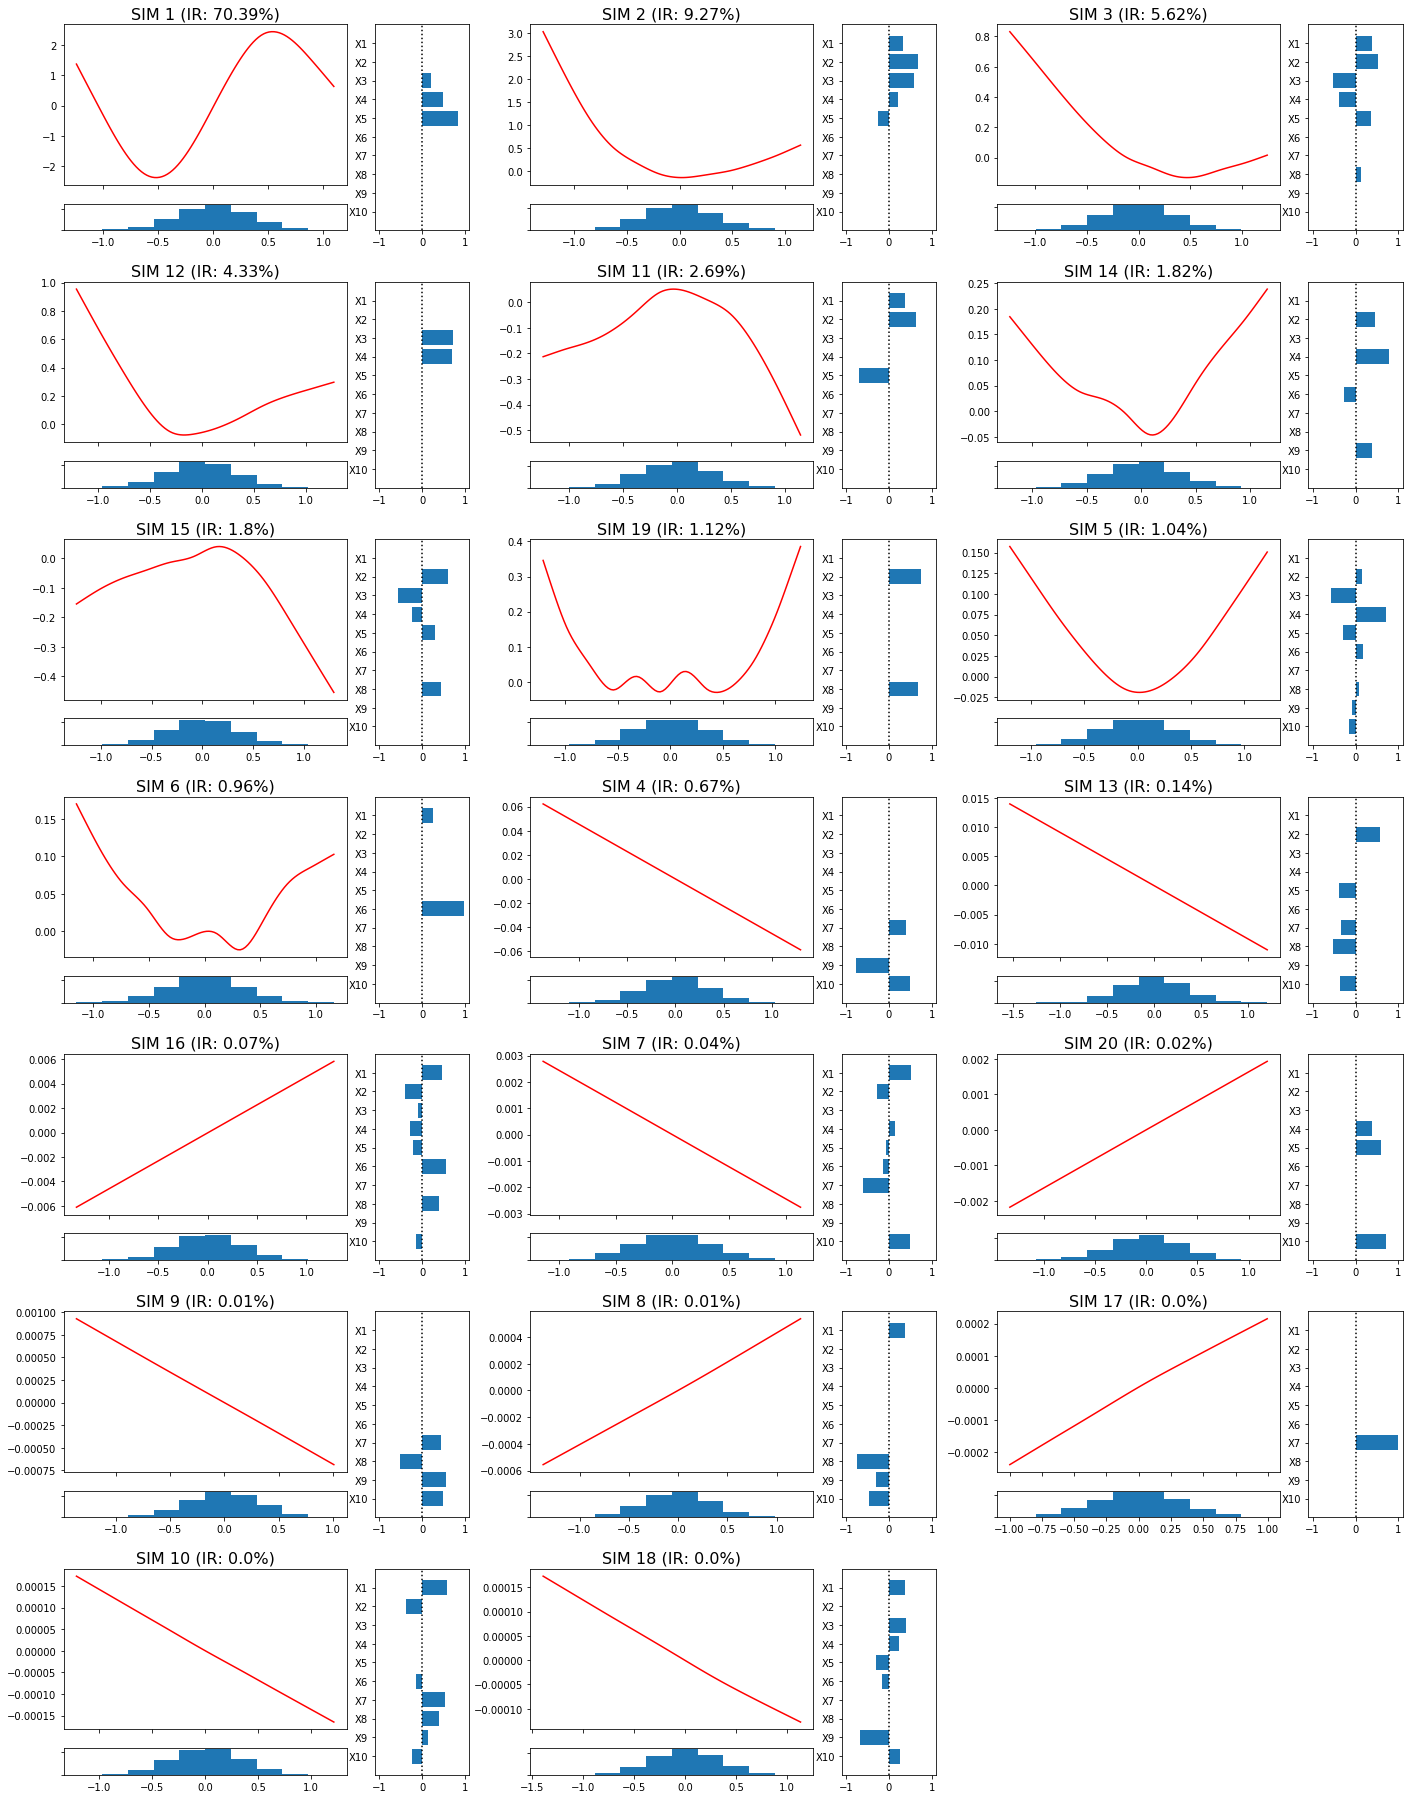

In [4]:
clf.visualize()

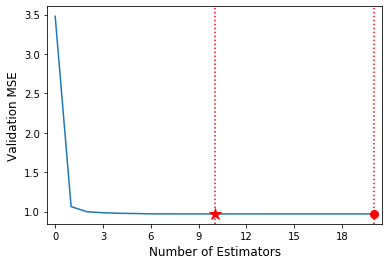

In [5]:
clf.validation_performance()

In [6]:
mean_squared_error(test_y, clf.predict(test_x))

1.0041786393059844

## LogitBoost

In [7]:
random_state = 0
np.random.seed(random_state)
# data generation
beta1 = np.array([.2, 0.3, 0.5, 0, 0, 0, 0, 0, 0, 0])
beta2 = np.array([0, .2, 0.3, 0.5, 0, 0, 0, 0, 0, 0])
beta3 = np.array([0, 0, 0.2, 0.3, 0.5, 0, 0, 0, 0, 0])
beta = np.vstack([beta1, beta2, beta3])

x = truncnorm.rvs(a=-3, b=3, loc = 0, scale=1 / 3, size=(10000, 10), random_state=random_state)
y = np.reshape(0.2 * np.exp(-4 * np.dot(x, beta1)) + \
               3 * (np.dot(x, beta2)) ** 2 + 2.5 * np.sin(np.pi * 1.5 * np.dot(x, beta3)), [-1, 1]) + \
    np.random.randn(10000).reshape(-1, 1)
y[y <= 0] = 0
y[y > 0] = 1
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

In [8]:
%%time 

middle_update = {"method":"bfgs",
                 "tol":0.0001,
                 "max_middle_iter":3,
                 "n_middle_iter_no_change":3, 
                 "max_inner_iter":20,
                 "learning_rate":1e-3,
                 "stratify":True,
                 "verbose":False}

clf = SimBoostClassifier(n_estimators=10, knot_num=10, knot_dist="quantile", spline="smoothing_spline", learning_rate=1,
                         reg_lambda=[0.1, 0.2, 0.3, 0.4, 0.5], degree=3, 
                         reg_gamma="GCV", middle_update=middle_update, meta_info=None)
clf.fit(train_x, train_y)
clf.visualize()

R[write to console]: Error in makessa(formula, data, type, nknots, rparm, lambdas, skip.iter,  : 
  Minimum weight is too small (less than 0.005).

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/share/R/library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/share/R/library’ contains no packages

/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
rpy2.rinterface_lib.embedded.RRuntimeError: Error in makessa(formula, data, type, nk

RRuntimeError: Error in makessa(formula, data, type, nknots, rparm, lambdas, skip.iter,  : 
  Minimum weight is too small (less than 0.005).


In [9]:
clf.validation_performance()

NotFittedError: This SimBoostClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
roc_auc_score(test_y, clf.predict_proba(test_x))

In [16]:
from pysim import *
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import softmax
from sklearn.compose import ColumnTransformer
from sklearn.utils import check_X_y, column_or_1d
from sklearn.utils.validation import check_is_fitted
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit, train_test_split
from sklearn.preprocessing import LabelBinarizer, FunctionTransformer, OneHotEncoder
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin, is_classifier, is_regressor

x = train_x
y = train_y

x, y = clf._validate_input(x, y)
n_samples, n_features = x.shape
clf._validate_hyperparameters()
clf._preprocess_meta_info(n_features)
sample_weight = clf._validate_sample_weight(n_samples, None)

clf.intercept_ = 0
clf.sim_estimators_ = []
clf.dummy_estimators_ = []
clf.dummy_density_ = {}
clf.learning_rates = [1] + [clf.learning_rate] * (clf.n_estimators - 1)

clf.tr_idx, clf.val_idx = train_test_split(np.arange(n_samples), test_size=clf.val_ratio,
                              stratify=y, random_state=clf.random_state)


n_samples = x.shape[0]
val_fold = np.ones((n_samples))
val_fold[clf.tr_idx] = -1

# Initialize the intercept
z = y.copy() * 4 - 2
clf.intercept_ = np.mean(z)
pred_train = clf.intercept_ * np.ones(len(clf.tr_idx))
pred_val = clf.intercept_ * np.ones(len(clf.val_idx))
proba_train = 1 / (1 + np.exp(-pred_train.ravel()))
proba_val = 1 / (1 + np.exp(-pred_val.ravel()))

sample_weight[clf.tr_idx] = proba_train * (1 - proba_train)
sample_weight[clf.tr_idx] /= np.sum(sample_weight[clf.tr_idx])
sample_weight[clf.tr_idx] = np.maximum(sample_weight[clf.tr_idx], 2 * np.finfo(np.float64).eps)

with np.errstate(divide="ignore", over="ignore"):
	z = np.where(y.ravel(), 1. / np.hstack([proba_train, proba_val]),
					-1. / (1. - np.hstack([proba_train, proba_val]))) 
	z = np.clip(z, a_min=-8, a_max=8)

# Fit categorical variables
if clf.cfeature_num_ > 0:
	clf._fit_dummy(x[clf.tr_idx], z[clf.tr_idx], sample_weight[clf.tr_idx])
	pred_train = np.sum([est.predict(x[clf.tr_idx]) for est in clf.dummy_estimators_], axis=0) + clf.intercept_
	proba_train = 1 / (1 + np.exp(-pred_train.ravel()))
	pred_val = np.sum([est.predict(x[clf.val_idx]) for est in clf.dummy_estimators_], axis=0) + clf.intercept_
	proba_val = 1 / (1 + np.exp(-pred_val.ravel()))


for indice in range(clf.n_estimators):
	sample_weight[clf.tr_idx] = proba_train * (1 - proba_train)
	sample_weight[clf.tr_idx] /= np.sum(sample_weight[clf.tr_idx])
	sample_weight[clf.tr_idx] = np.maximum(sample_weight[clf.tr_idx], 2 * np.finfo(np.float64).eps)

	with np.errstate(divide="ignore", over="ignore"):
		z = np.where(y.ravel(), 1. / np.hstack([proba_train, proba_val]),
						-1. / (1. - np.hstack([proba_train, proba_val]))) 
		z = np.clip(z, a_min=-8, a_max=8)

	# projection matrix
	if clf.learning_rate == 1:
		if (indice == 0) or (indice >= clf.nfeature_num_) or (clf.ortho_shrink == 0):
			proj_mat = np.eye(clf.nfeature_num_)
		else:
			projection_indices_ = np.array([est["sim"].beta_.flatten() for est in clf.sim_estimators_]).T
			u, _, _ = np.linalg.svd(projection_indices_, full_matrices=False)
			proj_mat = np.eye(u.shape[0]) - clf.ortho_shrink * np.dot(u, u.T)
	else:
		proj_mat = None

	# fit Sim estimator
	param_grid = {"method": clf.prjection_method_list, 
			  "reg_lambda": clf.reg_lambda_list,
			  "reg_gamma": clf.reg_gamma_list}
	grid = GridSearchCV(SimRegressor(degree=clf.degree, knot_num=clf.knot_num, spline=clf.spline,
						  knot_dist=clf.knot_dist, random_state=clf.random_state), 
				  scoring={"mse": make_scorer(mean_squared_error, greater_is_better=False)}, refit=False,
				  cv=PredefinedSplit(val_fold), param_grid=param_grid, verbose=0, error_score=np.nan)

	grid.fit(x[:, clf.nfeature_index_list_], z, sample_weight=sample_weight, proj_mat=proj_mat)
	sim = grid.estimator.set_params(**grid.cv_results_["params"][np.where((grid.cv_results_["rank_test_mse"] == 1))[0][0]])
	sim_estimator = Pipeline(steps = [("select", FunctionTransformer(lambda data: data[:, clf.nfeature_index_list_], 
												validate=False)),
						   ("sim", sim)])
	sim_estimator.fit(x[clf.tr_idx], z[clf.tr_idx],
				sim__sample_weight=sample_weight[clf.tr_idx], sim__proj_mat=proj_mat)

	# update
	sim_estimator["sim"].fit_middle_update(x[:, clf.nfeature_index_list_], z, 
			sample_weight=sample_weight, proj_mat=proj_mat, val_ratio=clf.val_ratio, **clf.middle_update)
	pred_train += clf.learning_rates[indice] * sim_estimator.predict(x[clf.tr_idx])
	proba_train = 1 / (1 + np.exp(-pred_train.ravel()))
	pred_val += clf.learning_rates[indice] * sim_estimator.predict(x[clf.val_idx])
	proba_val = 1 / (1 + np.exp(-pred_val.ravel()))
	clf.sim_estimators_.append(sim_estimator)

R[write to console]: Error in makessa(formula, data, type, nknots, rparm, lambdas, skip.iter,  : 
  Minimum weight is too small (less than 0.005).

/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
rpy2.rinterface_lib.embedded.RRuntimeError: Error in makessa(formula, data, type, nknots, rparm, lambdas, skip.iter,  : 
  Minimum weight is too small (less than 0.005).


  FitFailedWarning)
R[write to console]: Error in makessa(formula, data, type, nknots, rparm, lambdas, skip.iter,  : 
  Minimum weight is too small (less than 0.005).

/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
rpy2.rinterface_lib.embedded.R

RRuntimeError: Error in makessa(formula, data, type, nknots, rparm, lambdas, skip.iter,  : 
  Minimum weight is too small (less than 0.005).


In [25]:
np.min(sample_weight[clf.tr_idx] * 6400) 

0.003555063726341496

In [27]:
0.003555063726341496 / len(clf.tr_idx) 

5.554787072408588e-07